<a href="https://colab.research.google.com/github/luigiselmi/dl_tensorflow/blob/main/advanced_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Deep Learning for Computer Vision
In this notebook we deal with another fundamental tasks in computer vision: semantic segmentation. In semantic segmentation each pixel of an image is assigned a class so that each pixel is part of a group and the image is separated in clusters of pixels. The semantic segmentation assigns the same value to all the pixels of a certain class even if they belong to different objects of the same type. In a slightly different task, named instance segmentation, the algorithm is able to classify a pixel and also tell which cluster it belongs to. An object detection algorithm is able to detect the location of the object in the image by adding a bounding box around it with a label for its class.

In [1]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
import time

## Semantic segmentation
We will use the [Oxford-IIIT Pets](https://www.robots.ox.ac.uk/~vgg/data/pets/) dataset. it contains 7390 JPG RGB images with 8 bit depth so that the pixel value ranges between 0 and 255. Each image has a corresponding target raster PNG image of the same size, i.e. height and width, of the input image where each pixel can take one of three values

* 1 for the foreground
* 2 for the background
* 3 for the contour

We download and untar the input images and the annotated raster files.  

In [2]:
!wget -q --show-progress http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget -q --show-progress http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz;
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

images.tar.gz       100%[===================>] 755.23M  23.9MB/s    in 31s     
annotations.tar.gz  100%[===================>]  18.28M  9.32MB/s    in 2.0s    


After unzipping the data, we have two folders: one, _images/_, that contains all the jpg images and the other, _annotations/trimaps/_, that contains the corresponding masks. We open one image and its mask. We can see that they have the same size, i.e. height and width. The mask has only one channel.

In [3]:
from PIL import Image
img = Image.open('/content/images/Abyssinian_1.jpg')
img.size

(600, 400)

In [4]:
annotation = Image.open('/content/annotations/trimaps/Abyssinian_1.png')
annotation.size

(600, 400)

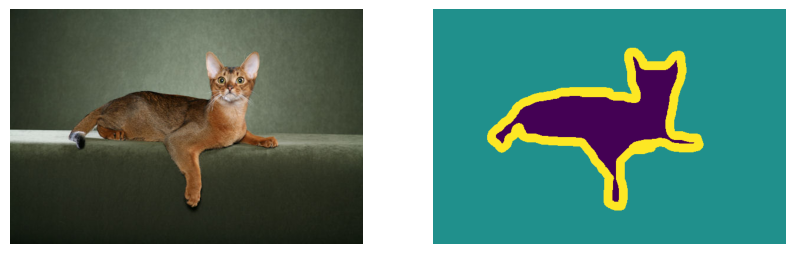

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
ax[0].axis("off")
ax[1].axis("off")
ax[0].imshow(img)
ax[1].imshow(annotation)

In [6]:
import os
input_dir = "images/"
target_dir = "annotations/trimaps/"
input_file_list = [os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(".jpg")]
input_img_paths = sorted(input_file_list)
print('Number of images: {:d}'.format(len(input_img_paths)))

Number of images: 7390


In [7]:
target_file_list = [os.path.join(target_dir, fname) for fname in os.listdir(target_dir) if fname.endswith(".png") and not fname.startswith(".")]
target_paths = sorted(target_file_list)
print('Number of masks: {:d}'.format(len(target_paths)))

Number of masks: 7390


We shuffle the images then we load them into NumPy arrays

In [8]:
import random
num_imgs = len(input_img_paths)
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

We define a function to load an image and transform it into a NumPy array

In [9]:
img_size = (200, 200)
def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

and to load a mask and transform it into a NumPy array as well

In [10]:
def path_to_target(path):
    img = img_to_array(load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1
    return img

## Loading images and masks into NumPy arrays
We load the images into arrays of float32 and the target files into arrays of 8 bit integers

In [31]:
input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

## Memory usage for the images and masks arrays
Storing all the images and masks in memory consume a total of 3.30 GB for the images and 280 MB for the masks. We can easily calculate the memory space required. In Google Colab we can also see the available RAM resources going down by the same size.  

In [32]:
print('Input images array: ', input_imgs.shape)

Input images array:  (7390, 200, 200, 3)


In [26]:
images_mem_size = (input_imgs.shape[0] * input_imgs.shape[1] * input_imgs.shape[2] * input_imgs.shape[3]) * 4 / 1024 ** 3
print('Memory size used for the images: {:.2f} GB'.format(images_mem_size))

Memory size used for the images: 3.30 GB


In [27]:
print('Input masks array: ', targets.shape)

Input masks array:  (7390, 200, 200, 1)


In [28]:
masks_mem_size = (targets.shape[0] * targets.shape[1] * targets.shape[2] * targets.shape[3]) * 1 / 1024 ** 3
print('Memory size used for the masks: {:.2f} GB'.format(masks_mem_size))

Memory size used for the masks: 0.28 GB


## Splitting the data into train, validation, and test arrays
Now we split the arrays into a training and a validation set. The validation set contains 1000 pairs of images and masks.

In [ ]:
num_test_samples = 1000
num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples -num_test_samples]
train_targets = targets[:-num_val_samples -num_test_samples]
val_input_imgs = input_imgs[-num_val_samples -num_test_samples:-num_test_samples]
val_targets = targets[-num_val_samples - num_test_samples:-num_test_samples]
test_input_imgs = input_imgs[-num_test_samples:]
test_targets = targets[-num_test_samples:]
print("Number of training input images:", len(train_input_imgs))
print("Number of validation input images:", len(val_input_imgs))
print("Number of test input images:", len(test_input_imgs))
print("Number of training targets:", len(train_targets))
print("Number of validation targets:", len(val_targets))
print("Number of test targets:", len(test_targets))

Number of training input images: 5390
Number of validation input images: 1000
Number of test input images: 1000
Number of training targets: 5390
Number of validation targets: 1000
Number of test targets: 1000


## Building the model
Now we define the model. The size of the input images is 200x200 and after a normalization of the values we apply 6 convolutional layers and 6 transposed convolutional layers. We use padding "same" in all the convolutional layer.

In [ ]:
def build_model(img_size, num_classes):
    kernal_size = (3, 3)
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(64, kernal_size, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, kernal_size, strides=1, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, kernal_size, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, kernal_size, strides=1, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, kernal_size, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, kernal_size, strides=1, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, kernal_size, strides=1, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, kernal_size, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, kernal_size, strides=1, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, kernal_size, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, kernal_size, strides=1, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, kernal_size, strides=2, activation="relu", padding="same")(x)
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)
    model = keras.Model(inputs, outputs)
    return model

The first part of the model, let's call it the encoder, uses convolutional layers in a way similar to that we used for image classification: we reduce the size of the feature maps and increase their number from the 3 RGB channels to 256 filters. The reduction of the height and width is done using a stride 2 instead of a MaxPooling layer. This technique preserves a feature's location since it is relevant for a segmentation task. The second part of the model, let's call it the decoder, uses a different type of convolutional layer called transpose and the number of feature maps decreases while their size increases till becoming of the same size of the input. The purpose of the decoder part is to learn how to upsample the feature maps so that it can apply the information learnt from the encoder to each pixel in the input image.

![segmentation architecture](https://github.com/luigiselmi/dl_tensorflow/blob/main/images/segmentation_architecture.jpg?raw=1)

For the 1st convolutional layer the kernel size is k = 3 with strides s = 2 so we are in a zero padding, p = 1, non-unit strides case and the output size is

$$o = \frac {i + 2p - k}{s} + 1 = \frac {200 + 2 - 3}{2} + 1 = 99 + 1 = 100$$

where we have calculated the minimum integer of the fraction. The 2nd convolutional layer is a zero padding p = 1, unit strides s = 1 so the size of the output is

$$o = (i - k) + 2p + 1 = (100 - 3) + 2 + 1 = 100$$

So the output of the 2nd convolutional layer has the same height and width of the input and also the number of filters is the same. The logic for the encoder part of the architecture is the same for the next 4 convolutional layers: a reduction of the height and width and an increase of the number of filters. Now we move to the decoder part to do the arithmetic for the transposed convolutions. We start from the last convolutional layer of the encoder with size 25 x 25 and 256 filters. The purpose now is to project the feature maps to a higher-dimensional space, e.g. from 25 x 25 to 50 x 50. The 1st transposed convolution is a zero padding p = 1, unit strides s = 1 case and the output size is the same as the input, that is 25 x 25. The strides of the 2nd transposed convolution is s = 2 with zero padding p = 1 so the output size is

$$o = s(i - 1) + k - 2p = 2(25 - 1) + 3 - 2 = 49 (+ 1) = 50$$

We add 1 to the result since $i + 2p -k == sm$ where m is an integer. In other words $i + 2p -k$ must be a multiple of s. The number of filters of the 2nd transposed convolution is still 256. The logic for the transposed convolution applies for the next 4 transposed convolutions till the last one where we have the same shape as the input, 200 x 200, and 3 filters.

In [ ]:
model = build_model(img_size=img_size, num_classes=3)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 100, 100, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 100, 100, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 50, 50, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 50, 50, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 25, 25, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 50, 50, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 50, 50, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 100, 100, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 100, 100, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 200, 200, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 200, 200, 3)         │           1,731 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,880,643 (10.99 MB)

 Trainable params: 2,880,643 (10.99 MB)

 Non-trainable params: 0 (0.00 B)

## Model compilation and training
We compile the model and define the callbacks to be used for the training. At each epoch we save the weights if the validation loss is lower than before. We use the [sparse categorical cross-entropy](https://keras.io/api/losses/probabilistic_losses/#sparse_categorical_crossentropy-function) function for the multi-class classification of the pixels in one of the three classes: foreground, background, and contour.

In [ ]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
    save_best_only=True)
]

In [ ]:
history = model.fit(train_input_imgs, train_targets,
                    epochs=50,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - loss: 0.8917 - val_loss: 0.9121
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 0.8505 - val_loss: 0.8171
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 0.8244 - val_loss: 0.8137
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 0.8133 - val_loss: 0.7649
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 0.7715 - val_loss: 0.7600
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 0.7604 - val_loss: 0.9343
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 0.7841 - val_loss: 0.7246
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 0.7425 - val_loss: 0.7464
Epoch 9/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 0.7143 - val_loss: 0.7762
Epoch 10/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 0.7081 - val_loss: 0.7029
Epoch 11/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 0.6753 - val_loss: 0.8639
Epoch 12/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 0

## Model performance
We assess the model performance on the validation set and on the test set.

In [ ]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]

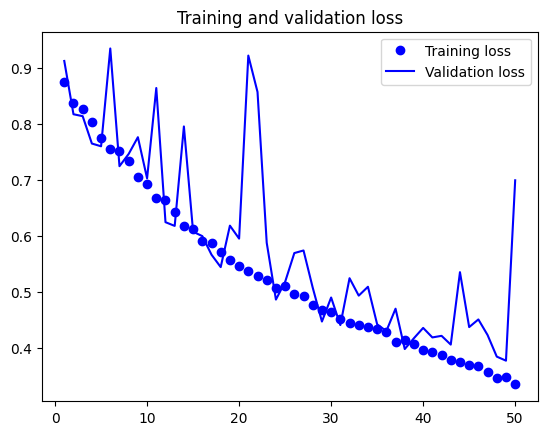

In [ ]:
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

We assess the model performance on some images from the test set to see whether the segmentation mask resembles the shape of the cat or dog in the input image. We load the best performing model that was saved before during the training.

In [ ]:
from tensorflow.keras.utils import array_to_img
best_model = keras.models.load_model("oxford_segmentation.keras")

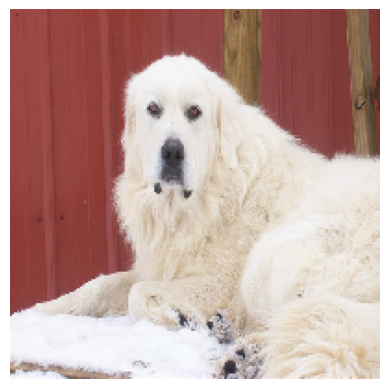

In [ ]:
i = 3
test_image = test_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

In [ ]:
predicted_mask = best_model.predict(np.expand_dims(test_image, 0))[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [ ]:
def display_mask(pred):
    mask = np.argmax(predicted_mask, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

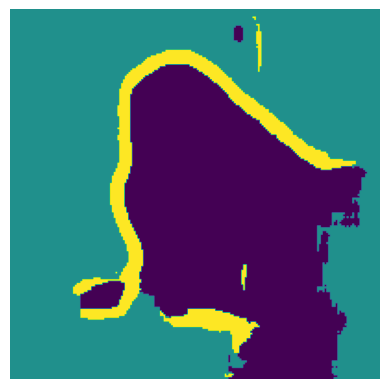

In [ ]:
display_mask(predicted_mask)

## References
* [Dumoulin, Visin - A guide to convolution arithmetic for deep learning](https://arxiv.org/abs/1603.07285)